In [1]:
import pandas as pd
import numpy as np
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import iqr
from samples_dict import samples_dict

def summary_stats(ts):
    """
    Caclulates lots of (mostly) traditional statistics,
    that are summaries of the site frequency spectrum.

    Arguments
    ---------
    data: Named tuple of results (made by collate_results function)

    Returns
    ---------
    Nested dictionary of statistics

    """
    pop_dict = {"domestic":0, "scot":1, "captive":2, "eu":3, "lyb":4}

    stats = {
        "diversity": {},
        "segregating_sites": {},
        "tajimas_d": {},
        "divergence": {},
        "relatedness": {},
        "fst": {},
        "f2": {},
        "f3": {},
        "f4": {},
        "y1": {},
        "y2": {},
        "y3": {},
        "pc1_median":{},
        "pc2_median":{},
        "pc1_iqr":{},
        "pc2_iqr":{},
        "pc1_dist":{},
        "pc2_dist":{}
    }

    # One way statistics
    for pop_name, pop_num in pop_dict.items():
        stats["diversity"][pop_name] = ts.diversity(sample_sets=ts.samples(population=pop_num))
        stats["segregating_sites"][pop_name] = ts.segregating_sites(sample_sets=ts.samples(population=pop_num))
        stats["tajimas_d"][pop_name] = ts.Tajimas_D(sample_sets=ts.samples(population=pop_num))
        stats["y1"][pop_name] = ts.Y1(sample_sets=ts.samples(population=pop_num))

    # Two way statistics
    for comparison in ["domestic_scot", "domestic_captive", "domestic_eu", "domestic_lyb",
                       "scot_captive", "scot_eu", "scot_lyb", "captive_eu", "captive_lyb", "eu_lyb"]:
        p = comparison.split("_")
        stats["divergence"][comparison] = ts.divergence(sample_sets = [ts.samples(population=pop_dict[p[0]]),
                                                                       ts.samples(population=pop_dict[p[1]])])
        stats["relatedness"][comparison] = ts.genetic_relatedness(sample_sets=[ts.samples(population=pop_dict[p[0]]),
                                                                               ts.samples(population=pop_dict[p[1]])])
        stats["fst"][comparison] = ts.Fst(sample_sets=[ts.samples(population=pop_dict[p[0]]),
                                                       ts.samples(population=pop_dict[p[1]])])
        stats["f2"][comparison] = ts.f2(sample_sets=[ts.samples(population=pop_dict[p[0]]),
                                                     ts.samples(population=pop_dict[p[1]])])
        stats["y2"][comparison] = ts.Y2(sample_sets=[ts.samples(population=pop_dict[p[0]]),
                                                     ts.samples(population=pop_dict[p[1]])])

    # Three way statistics
    for comparison in ["domestic_scot_captive", "domestic_scot_eu", "domestic_scot_lyb", "domestic_captive_eu",
                       "domestic_captive_lyb", "domestic_eu_lyb", "scot_captive_eu", "scot_captive_lyb", "scot_eu_lyb",
                       "captive_eu_lyb"]:
        p = comparison.split("_")
        stats["f3"][comparison] = ts.f3(sample_sets = [ts.samples(population=pop_dict[p[0]]),
                                                       ts.samples(population=pop_dict[p[1]]),
                                                       ts.samples(population=pop_dict[p[2]])])
        stats["y3"][comparison] = ts.Y3(sample_sets = [ts.samples(population=pop_dict[p[0]]),
                                                       ts.samples(population=pop_dict[p[1]]),
                                                       ts.samples(population=pop_dict[p[2]])])
    # Four way statistics
    for comparison in ["domestic_scot_captive_eu", "domestic_scot_captive_lyb","domestic_captive_eu_lyb",
                       "domestic_scot_eu_lyb", "scot_captive_eu_lyb"]:
        p = comparison.split("_")
        stats["f4"][comparison] = ts.f4(sample_sets=[ts.samples(population=pop_dict[p[0]]),
                                                     ts.samples(population=pop_dict[p[1]]),
                                                     ts.samples(population=pop_dict[p[2]]),
                                                     ts.samples(population=pop_dict[p[3]])])

    ##### PCA summary stats #####
    genotype = ts.genotype_matrix()

    # minor allele frequency filter NOT NEEDED
    '''
    frequency = np.count_nonzero(genotype == 1, axis=1) / np.shape(genotype)[1]

    maf = np.zeros(np.shape(frequency)[0])

    for num in range(0, np.shape(frequency)[0]):
        maf[num] = np.any([frequency[num] < 0.05, frequency[num] > 0.95])

    maf = maf.astype(dtype=bool)
    filtered_01 = genotype[~maf]
    '''

    # convert from 01 to 012
    samples = np.shape(genotype)[1]
    ones = []
    twos = []

    for col in range(0, samples):
        if col % 2 == 0:
            ones.append(col)
        else:
            twos.append(col)

    matrix_012 = np.add(genotype[:, ones], genotype[:, twos])

    # scaled PCA
    standardizedData = StandardScaler().fit_transform(matrix_012.T)

    pca = PCA(n_components=2)

    principalComponents = pca.fit_transform(X=standardizedData)

    pca_df = pd.DataFrame(principalComponents, columns=['pc1', 'pc2'])
    pops = samples_dict.values()
    pca_df["pop"] = pops

    # PCA stats
    pop_names = ["domestic", "scot", "captive", "eu", "lyb"]

    stats_df = pca_df.groupby("pop").agg((np.median, iqr))
    stats_dict = stats_df.to_dict()

    # individual median and iqr
    for pop in pop_names:
        stats["pc1_median"][pop] = stats_dict[('pc1', 'median')][pop]
        stats["pc2_median"][pop] = stats_dict[('pc2', 'median')][pop]
        stats["pc1_iqr"][pop] = stats_dict[('pc1', 'iqr')][pop]
        stats["pc2_iqr"][pop] = stats_dict[('pc2', 'iqr')][pop]

    # pairwise median comparisons
    for comparison in ["domestic_scot", "domestic_captive", "domestic_eu", "domestic_lyb",
                       "scot_captive", "scot_eu", "scot_lyb", "captive_eu", "captive_lyb", "eu_lyb"]:
        p = comparison.split("_")
        stats["pc1_dist"][comparison] = abs(stats_dict[('pc1', 'median')][p[0]] - stats_dict[('pc1', 'median')][p[1]])
        stats["pc2_dist"][comparison] = abs(stats_dict[('pc2', 'median')][p[0]] - stats_dict[('pc2', 'median')][p[1]])

    ref_table = pd.DataFrame(flatten_dict(stats), index=['i', ])


    return ref_table, pca_df

In [2]:
def flatten_dict(d, sep='_'):
    """
    Recursively flattens a nested dictionary, concatenating the outer and inner keys.

    Arguments
    -----------
    stats_dict: A nested dictionary of statistics
    sep: seperator for keys

    Returns
    ------------
    dict
    """

    def items():
        for key, value in d.items():
            if isinstance(value, dict):
                for subkey, subvalue in flatten_dict(value).items():
                    yield key + sep + subkey, subvalue
            else:
                yield key, value

    return dict(items())

In [3]:
ts = pd.read_pickle(r'./tsinfer_tree.pickle')

In [4]:
ref_table, pca = summary_stats(ts)
ref_table.to_csv("./observed_stats.csv", index = False)

C:\Users\harrg\AppData\Local\Temp\ipykernel_17552\1008635099.py:131: FutureWarning: The provided callable <function median at 0x00000222C1E332E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats_df = pca_df.groupby("pop").agg((np.median, iqr))
C:\Users\harrg\AppData\Local\Temp\ipykernel_17552\1008635099.py:131: FutureWarning: The provided callable <function median at 0x00000222C1E332E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats_df = pca_df.groupby("pop").agg((np.median, iqr))


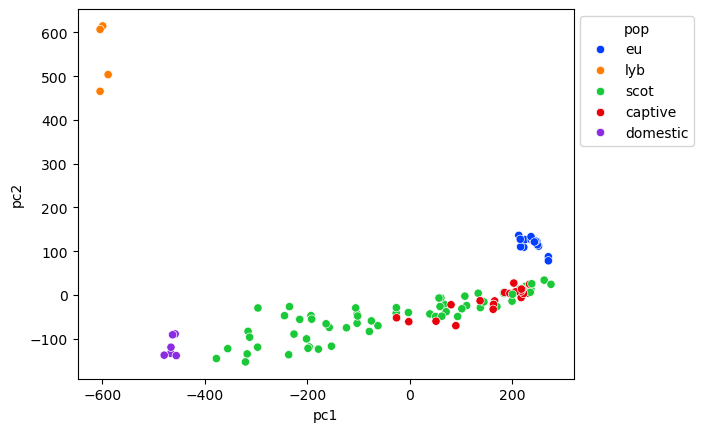

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
import pandas as pd
from samples_dict import samples_dict

##### PCA summary stats #####
genotype = ts.genotype_matrix()

# minor allele frequency filter NOT NEEDED
'''
frequency = np.count_nonzero(genotype == 1, axis=1) / np.shape(genotype)[1]

maf = np.zeros(np.shape(frequency)[0])

for num in range(0, np.shape(frequency)[0]):
    maf[num] = np.any([frequency[num] < 0.05, frequency[num] > 0.95])

maf = maf.astype(dtype=bool)
filtered_01 = genotype[~maf]
'''

# convert from 01 to 012
samples = np.shape(genotype)[1]
ones = []
twos = []

for col in range(0, samples):
    if col % 2 == 0:
        ones.append(col)
    else:
        twos.append(col)

matrix_012 = np.add(genotype[:, ones], genotype[:, twos])

# scaled PCA

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])

principalComponents = pipeline.fit_transform(matrix_012.T)

pca_df = pd.DataFrame(principalComponents, columns=['pc1', 'pc2'])
pops = samples_dict.values()
pca_df["pop"] = pops

ax = sns.scatterplot(pca_df, x=pca_df["pc1"], y=pca_df["pc2"], hue=pca_df["pop"], palette = "bright")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))